In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [22]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')

cuda:0 is available


In [14]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features =  nn.Sequential(
            nn.Conv2d(3,64,3), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,192,3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(192,384,3, padding=1), nn.ReLU(),
            nn.Conv2d(384,256,3, padding=1), nn.ReLU(),
            nn.Conv2d(256,256,1), nn.ReLU(),
            nn.MaxPool2d(2,2)
            
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*3*3,1024), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024,512), nn.ReLU(),
            nn.Linear(512,10)



        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,256*3*3)
        x = self.classifier(x)
        return x


In [15]:
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [16]:
iter(trainloader).next()[0].size()

torch.Size([32, 3, 32, 32])

In [17]:
loss_ = []
n = len(trainloader)

for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_.append(running_loss / n)
    print('[%d] loss: %.3f'%(epoch+1, running_loss / n))

[1] loss: 1.662
[2] loss: 1.256
[3] loss: 1.074
[4] loss: 0.963
[5] loss: 0.866
[6] loss: 0.804
[7] loss: 0.752
[8] loss: 0.695
[9] loss: 0.661
[10] loss: 0.623
[11] loss: 0.589
[12] loss: 0.563
[13] loss: 0.540
[14] loss: 0.515
[15] loss: 0.489
[16] loss: 0.473
[17] loss: 0.453
[18] loss: 0.434
[19] loss: 0.417
[20] loss: 0.406
[21] loss: 0.390
[22] loss: 0.382
[23] loss: 0.373
[24] loss: 0.349
[25] loss: 0.347
[26] loss: 0.336
[27] loss: 0.324
[28] loss: 0.316
[29] loss: 0.304
[30] loss: 0.295
[31] loss: 0.287
[32] loss: 0.288
[33] loss: 0.262
[34] loss: 0.282
[35] loss: 0.267
[36] loss: 0.277
[37] loss: 0.249
[38] loss: 0.247
[39] loss: 0.262
[40] loss: 0.249
[41] loss: 0.238
[42] loss: 0.242
[43] loss: 0.268
[44] loss: 0.237
[45] loss: 0.244
[46] loss: 0.238
[47] loss: 0.209
[48] loss: 0.240
[49] loss: 0.255
[50] loss: 0.220


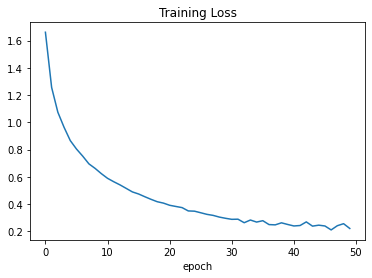

In [18]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [20]:
path = "./model/cifa_alexnet.pth"
torch.save(alexnet.state_dict(), path)

In [21]:
alexnet = AlexNet().to(device)
alexnet.load_state_dict(torch.load(path))

<All keys matched successfully>

In [23]:
correct = 0
total = 0
with torch.no_grad():
    alexnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print("Test accuracy: %.2f %%"%(100 * correct / total) )

Test accuracy: 74.32 %
